### 1 多分类

这个部分需要你实现手写数字(0到9)的识别。你需要扩展之前的逻辑回归，并将其应用于一对多的分类。

#### 数据集

这是一个MATLAB格式的.m文件，其中包含5000个20*20像素的手写字体图像，以及他对应的数字。另外，数字0的y值，对应的是10

用Python读取我们需要使用SciPy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat
from sklearn.metrics import classification_report   # 这个包是评价报告

In [2]:
data = loadmat('./ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
data['X'].shape, data['y'].shape

((5000, 400), (5000, 1))

#### 1.2 数据可视化

随机展示100个数据

In [4]:
sample_idx = np.random.choice(np.arange(data['X'].shape[0]), 100)
sample_images = data['X'][sample_idx, :]
sample_images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

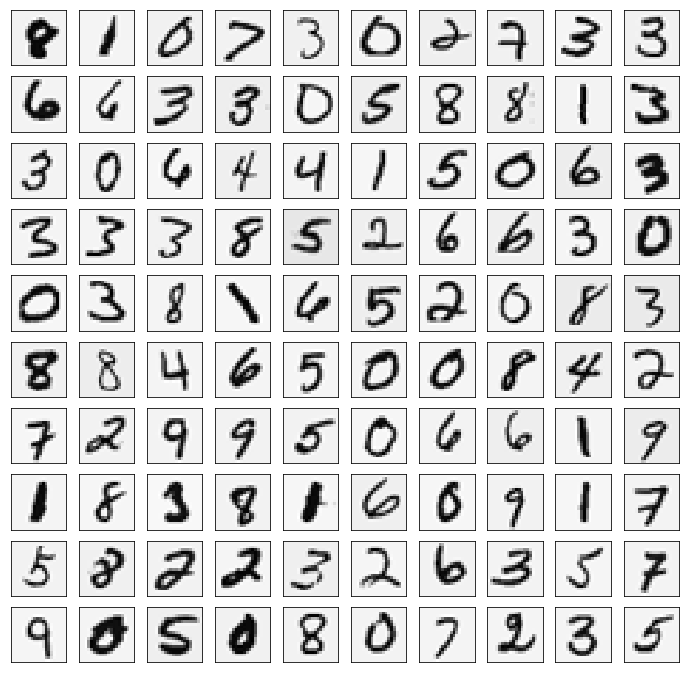

In [5]:
fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(12, 12))
for r in range(10):
    for c in range(10):
        ax_array[r, c].matshow(np.array(sample_images[10 * r + c].reshape((20, 20))).T, cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

#### 1.3 将逻辑回归向量化

你将用多分类逻辑回归做一个分类器。因为现在有10个数字类别，所以你需要训练10个不同的逻辑回归分类器。为了让训练效率更高，将逻辑回归向量化是非常重要的，不要用循环。

##### 1.3.1 向量化代价函数

#### sigmoid函数

g代表一个常用的逻辑函数(logistic function)为S形函数(Sigmoid function)，公式为：

$$
g(z) = \frac{1}{1+e^{-z}}
$$

合起来，我们得到逻辑回归模型的假设函数：

$$
h_{\theta}(x) = \frac{1}{1+e^{-\theta^{T}X}}
$$

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

代价函数：

$$
J(\theta) = \frac{1}{m} \sum_{i=1}^{m}[-y^{(i)}log(h_{\theta}(x^{(i)}))-(1-y^{(i)})log(1-h_{\theta}(x^{(i)}))]
$$

In [7]:
def cost(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1-y), np.log(1-sigmoid(X * theta.T)))
    reg = (learningRate / (2 * len(X))) * np.sum(np.power(theta[:, 1: theta.shape[1]], 2))

    return np.sum(first - second) / len(X) + reg

#### 1.3.2 向量化梯度

没正则化的时候，逻辑回归的代价是一个向量，第j个元素定义如下：

$$
\frac{\partial J}{\partial \theta_{j}} = \frac{1}{m} \sum_{i=1}^{m}((h_{\theta}(x^{(i)})-y^{(i)})x^{(i)}_j)
$$

想要正则化它，我们先把他每一行都写出来

$$
\begin{bmatrix}
\frac{\partial J}{\partial \theta_{0}}\\
\frac{\partial J}{\partial \theta_{1}}\\
\frac{\partial J}{\partial \theta_{2}}\\
...\\
\frac{\partial J}{\partial \theta_{n}}
\end{bmatrix}

=\frac{1}{m}

\begin{bmatrix}
\sum_{i=1}^{m}((h_{\theta}(x^{(i)})-y^{(i)})x^{(i)}_0)\\
\sum_{i=1}^{m}((h_{\theta}(x^{(i)})-y^{(i)})x^{(i)}_1)\\
\sum_{i=1}^{m}((h_{\theta}(x^{(i)})-y^{(i)})x^{(i)}_2)\\
...\\
\sum_{i=1}^{m}((h_{\theta}(x^{(i)})-y^{(i)})x^{(i)}_n)
\end{bmatrix}
$$

$$
=\frac{1}{m} \sum^{m}_{i=1}((h_{\theta}(x^{(i)})-y^{(i)})x^{(i)})
$$
$$
=\frac{1}{m} X^{T}(h_{\theta}(x)-y)
$$
其中
$$
h_{\theta}(x)-y=
\begin{bmatrix}
h_{\theta}(x^{(1)})-y^{(1)}\\
h_{\theta}(x^{(2)})-y^{(2)}\\
...\\
h_{\theta}(x^{(1)})-y^{(m)}
\end{bmatrix}
$$
记住，$x^{(i)}$是一个向量，但$(h_{\theta}(x^{(i)})-y^{(i)})$是一个数字

要理解前面式子的最后一步，我们令$\beta_{i}=(h_{\theta}(x^{(i)})-y^{(i)})$。于是我们可以得出如下等式

$$
\sum_{i} \beta_{i} x^{(i)}=
\begin{bmatrix}
|&|&&|\\
x^{(1)}&x^{(2)}&...&x^{(m)}\\
|&|&&|\\
\end{bmatrix}
\begin{bmatrix}
\beta_1\\
\beta_2\\
...\\
\beta_m\\
\end{bmatrix}
=X^{T}\beta
$$

$\sum_{i} \beta_{i} x^{(i)}$是n*1的向量，与一开始等式左边$\frac{\partial J}{\partial \theta_{n}}$的n*1向量对应，$X^{T}$后为n*m，$\beta_m$的列向量是m*1，二者相乘之后是n*1



##### 1.3.3 向量化正则化逻辑回归

梯度更新公式如下：

$$
\theta_{0} := \theta_{0} -  \alpha \frac{1}{m} \sum^{m}_{i=1}(h_{\theta}(x^{(i)})-y^{(i)})x^{(i)}_0
$$
$$
\theta_{0} := \theta_{0} -  \alpha \frac{1}{m} \sum^{m}_{i=1}(h_{\theta}(x^{(i)})-y^{(i)})x^{(i)}_j + \frac{\lambda}{m} \theta_j
$$

向量化后的梯度更新公式如下：

$$
\theta_{0} := \theta_{0}-\alpha \frac{1}{m}(h_{\theta}(x)-y)x_{0}
$$

$$
\theta_{j} := \theta_{j} - \alpha(\frac{1}{m} X^{T}(h_{\theta}(x)-y)+\frac{\lambda}{m}\theta_j)
$$


In [8]:
def gradient(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = int(theta.ravel().shape[1])
    error = sigmoid(X * theta.T) - y

    grad = ((X.T * error) / len(X)).T + ((learningRate / len(X)) * theta)

    # intercept gradient is not regularized
    grad[0, 0] = np.sum(np.multiply(error, X[:, 0])) / len(X)

    return np.array(grad).ravel()

#### 1.4 一对多分类器

现在我们已经定义了代价函数和梯度函数，现在是构建分类器的时候了。

对于这个任务，我们有10个可能的类，并且由于逻辑回归只能一次在2个类之间进行分类，我们需要多类分类的策略。

在本练习中，我们的任务是实现一对一全分类方法，其中具有k个不同类的标签就有k个分类器，每个分类器在"类别i"和"不是i"之间决定。

我们将把分类器包含在一个函数中，该函数计算10个分类器中的每个分类器的最终权重，并将权重返回为k*(n+1)数组，其中n是参数数量。

In [9]:
from scipy.optimize import minimize

def one_vs_all(X, y, num_labels, learning_rate):
    rows = X.shape[0]
    params = X.shape[1]

    # k * (n + 1) array for the parameters od each of the k classifiers
    all_theta = np.zeros((num_labels, params+1))

    # insert a column of ones at the beginning for the intercept term
    X = np.insert(X, 0, values=np.ones(rows), axis=1)

    # label are 1-indexed instead of 0-indexed
    for i in range(1, num_labels+1):
        theta = np.zeros(params+1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (rows, 1))

        # minimize the objective function
        fmin = minimize(fun=cost, x0=theta, args=(X, y_i, learning_rate), method='TNC', jac=gradient)
        all_theta[i-1, :] = fmin.x

    return all_theta

这里需要注意的几点：首先，我们为theta添加了一个额外的参数(与训练数据一列)，以计算截距项(常数项)。其次，我们将y从类标签转换为每个分类器的二进制值(要么是类i，要么不是类i)。最后，我们使用SciPy的较新优化API来最小化每个分类器的代价函数。如果指定的话，API将采用目标函数，初始参数集，优化方法和jacobian(渐变)函数。然后将优化程序找到的参数分配给参数数组。

实现向量化代码的一个更具挑战性的部分是正确地写入所有的矩阵，保证维度正确。

In [10]:
rows = data['X'].shape[0]
params = data['X'].shape[1]

all_theta = np.zeros((10, params+1))

X = np.insert(data['X'], 0, values=np.ones(rows), axis=1)

theta = np.zeros(params+1)

y_0 = np.array([1 if label == 0 else 0 for label in data['y']])
y_0 = np.reshape(y_0, (rows, 1))

X.shape, y_0.shape, theta.shape, all_theta.shape

((5000, 401), (5000, 1), (401,), (10, 401))

注意，theta是一维数组，因此当它被转换为计算梯度的代码中的矩阵时，它变为(1*401)矩阵。我们还检查y中的类标签，以确保它们看起来像我们想象的一致。

In [11]:
np.unique(data['y'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

让我们确保我们的训练函数正确运行，并且得到合理的输出。

In [12]:
all_theta = one_vs_all(data['X'], data['y'], 10, 1)
all_theta

array([[-2.38208691e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.30384042e-03, -6.14427666e-10,  0.00000000e+00],
       [-3.18352842e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.46123909e-03, -5.08642939e-04,  0.00000000e+00],
       [-4.79735416e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.87309679e-05, -2.47481807e-07,  0.00000000e+00],
       ...,
       [-7.98467966e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.97640711e-05,  7.23641521e-06,  0.00000000e+00],
       [-4.57003568e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.33433208e-03,  1.00011405e-04,  0.00000000e+00],
       [-5.40502829e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16485909e-04,  7.85363055e-06,  0.00000000e+00]])

##### 1.4.1 一对多预测

我们现在准备好最后一步，使用训练完毕的分类器预测每个图像的标签。对于这一步，我们将计算每个类的类概率，对于每个训练样本(使用当然的向量化代码)，并将输出类标签为具有最高概率的类。

In [13]:
def predict_all(X, all_theta):
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_theta.shape[0]

    # same as before, insert ones to match the shape
    X = np.insert(X, 0, values=np.ones(rows), axis=1)

    # convert to matrices
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)

    # compute the class probability for each class on each training instance
    h = sigmoid(X * all_theta.T)

    # create array of the index with the maximum probability
    h_argmax = np.argmax(h, axis=1)

    # because our array was zero-indexed we need to add one fir the true label prediction
    h_argmax = h_argmax + 1

    return h_argmax

现在我们可以使用predict_all函数为每个实例生成类预测，看看我们的分类器是如何工作的。

In [14]:
y_pred = predict_all(data['X'], all_theta)
print(classification_report(data['y'], y_pred))

              precision    recall  f1-score   support

           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500
          10       0.97      0.99      0.98       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



### 2 神经网络

在前面一个部分，我们已经实现了多分类逻辑回归来识别手写数字。但是，逻辑回归并不能承载更复杂的假设，因为他就是个线性分类器。
这部分，你需要实现一个可以识别手写数字的神经网络。神经网络可以表示一些非线性复杂的模型。权重已经预先训练好，你的目标是在现有权重基础上，实现前馈神经网络。

#### 2.1 模型表达

现有模型图示如下

![avatar](pic.png)

输入是图片的像素值，20*20像素的图片有400个输入层单元，不包括需要额外添加的加上常数项。
材料已经提供了训练好的神经网络的参数$\theta^{(1)}$, $\theta^{(2)}$,有25个隐层单元和10个输出单元（10个输出）

#### 2.2 前馈神经网络和预测

你需要实现前馈神经网络预测手写数字的功能。和之前的一对多分类一样，神经网络的预测会把中值最大的，作为预测输出

In [15]:
weight = loadmat('./ex3weights.mat')
theta1, theta2 = weight["Theta1"], weight["Theta2"]
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [16]:
X = data['X']
X_ones = np.ones(X.shape[0]).reshape(-1, 1)
X2 = np.matrix(np.hstack((X_ones, X)))
y2 = np.matrix(data['y'])
X2.shape, y2.shape

((5000, 401), (5000, 1))

In [17]:
a1 = X2
z2 = a1 * theta1.T
z2.shape

(5000, 25)

In [18]:
a2 = sigmoid(z2)
a2.shape

(5000, 25)

In [19]:
a2 = np.insert(a2, 0, values=np.ones(a2.shape[0]), axis=1)
z3 = a2 * theta2.T
z3.shape

(5000, 10)

In [20]:
a3 = sigmoid(z3)
a3

matrix([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
         4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
        [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
         2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
        [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
         6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
        ...,
        [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
         2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
        [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
         1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
        [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
         5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

In [21]:
y_pred2 = np.argmax(a3, axis=1) + 1
y_pred2.shape

(5000, 1)

In [22]:
print(classification_report(y2, y_pred))

              precision    recall  f1-score   support

           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500
          10       0.97      0.99      0.98       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000

